In [3]:
from utils.ModelWrapper import ModelWrapper
from models.DLinear.Model import Model as DLinear
from models.PatchTST.Model import Model as PatchTST
from models.SegRNN.Model import Model as SegRNN
import time
import torch
import matplotlib.pyplot as plt
from utils.generate_config import get_config_for
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

In [2]:
model_name = 'DLinear'
model_map = {
    'DLinear': DLinear,
    'PatchTST': PatchTST,
    'SegRNN': SegRNN
}
model_class = model_map[model_name]
pred_lens = [96, 192, 336, 720]
data_paths = ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv', 'electricity.csv', 'traffic.csv', 'weather.csv']
diffs = torch.zeros((len(data_paths), len(pred_lens), 3, 2))
for pred_len in pred_lens:
    for data_path in data_paths:
        model_wrapper1 = ModelWrapper(model_class, get_config_for(data_path, pred_len, model_name, training_type='normal'))
        model_wrapper2 = ModelWrapper(model_class, get_config_for(data_path, pred_len, model_name, training_type='occasional', n_iter=1))
        model_wrapper3 = ModelWrapper(model_class, get_config_for(data_path, pred_len, model_name, training_type='weighted'))

        models = [model_wrapper1, model_wrapper2, model_wrapper3]
        methods = ['Baseline', 'Occasional Robust Loss', 'Weighted Loss']

        for model, method in zip(models, methods):
            batch_idx = 0
            channel_idx = 0
            model.train()
            model.eval()
            model.config.batch_size = batch_idx + 1
            _, test_loader = model.get_data('test')
            for (batch_x, batch_y, _, _) in test_loader:
                break
            batch_x = batch_x.float().cuda()
            y_pred = model.forward(batch_x).cpu().detach()
            epsilon = 0.1
            lower_bound, upper_bound = batch_x - epsilon, batch_x + epsilon
            start = time.time()
            y_lower, y_upper = model.forward_bounds(lower_bound, upper_bound)
            y_lower, y_upper = y_lower.cpu().detach(), y_upper.cpu().detach()

            pred_len = model.config.pred_len
            y_lower = y_lower[batch_idx, -pred_len:, channel_idx]
            y_upper = y_upper[batch_idx, -pred_len:, channel_idx]

            mean = (y_upper - y_lower).mean()
            std = (y_upper - y_lower).std()
            diffs[data_paths.index(data_path), pred_lens.index(pred_len), methods.index(method)] = torch.stack([mean, std])

Loading trained model from:  ./trained_models/DLinear/ETTh1/96/normal
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/occasional/1
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/weighted
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/normal
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/1
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/weighted
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTm1/96/normal
test 11425
Loading trained model from:  ./trained_models/DLinear/ETTm1/96/occasional/1
test 11425
Loading trained model from:  ./trained_models/DLinear/ETTm1/96/weighted
test 11425
Loading trained model from:  ./trained_models/DLinear/ETTm2/96/normal
test 11425
Loading trained model from:  ./trained_models/DLinear/ETTm2/96/occasional/1
test 11425
Loading trained model from:  ./trained_models/DLinear/ETTm2/96/weighted
test 11425
Lo

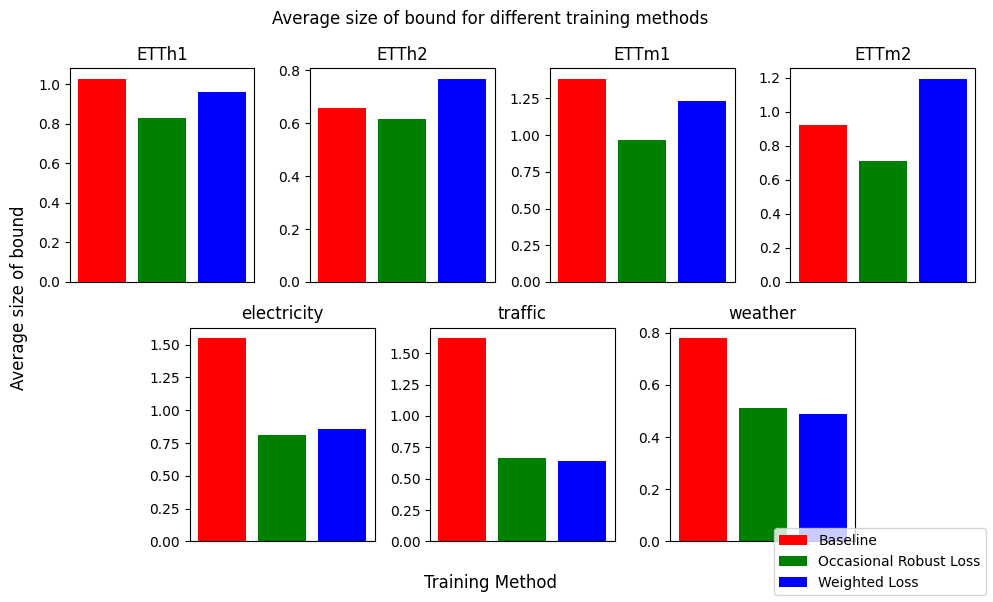

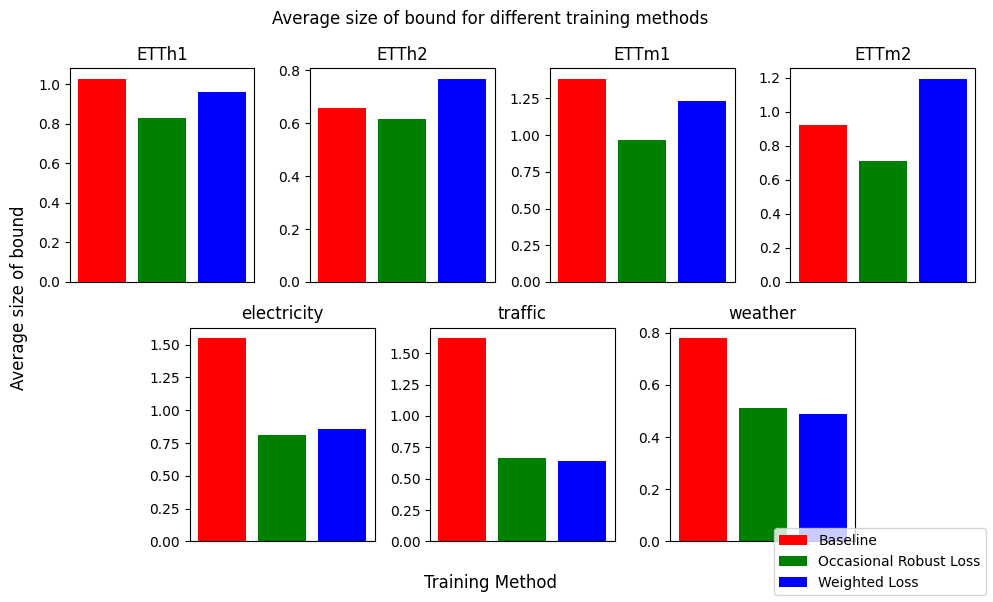

In [5]:
%matplotlib inline
metric = 1
metric_name = ['Mean Absolute Error', 'Mean Squared Error', 'Time (s)']
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 8)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[0, 6:8])

ax5 = fig.add_subplot(gs[1, 1:3])
ax6 = fig.add_subplot(gs[1, 3:5])
ax7 = fig.add_subplot(gs[1, 5:7])
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
colours = ['r', 'g', 'b']
for i, ax in enumerate(axs):
    x = torch.arange(len(methods))
    ax.bar(x, diffs.mean(dim=1)[i][:, 0], color=colours)
    ax.set_xticks([])
    ax.set_title(data_paths[i].split('.')[0])
fig.supxlabel('Training Method')
fig.supylabel('Average size of bound')
fig.suptitle('Average size of bound for different training methods')
fig.legend(handles=[Patch(facecolor=color, label=label) for color, label in zip(colours, methods)], loc='lower right')
fig.tight_layout()
plt.savefig(f'bound_sizes_{model}.png')
plt.show()

Loading trained model from:  ./trained_models/SegRNN/ETTh1/96/normal
test 2785
Loading trained model from:  ./trained_models/SegRNN/ETTh1/96/occasional/1
test 2785
Loading trained model from:  ./trained_models/SegRNN/ETTh1/96/weighted
test 2785


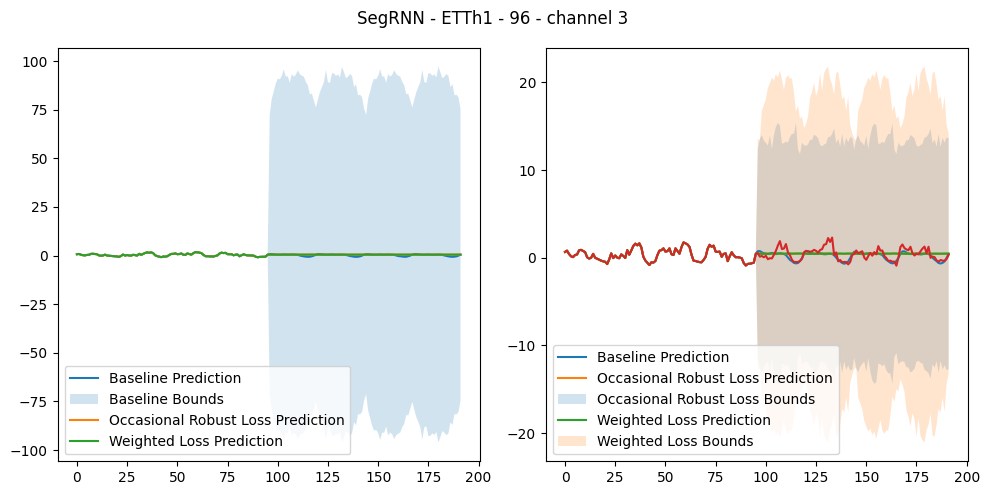

In [11]:
%matplotlib inline
model = 'SegRNN'
model_map = {
    'DLinear': DLinear,
    'SegRNN': SegRNN,
    'PatchTST': PatchTST
}
model_class = model_map[model]
dataset = 'ETTh1.csv'
model_wrapper1 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='normal'))
model_wrapper2 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='occasional', n_iter=1))
model_wrapper3 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='weighted'))

models = [model_wrapper1, model_wrapper2, model_wrapper3]
methods = ['Baseline', 'Occasional Robust Loss', 'Weighted Loss']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for model, method in zip(models, methods):
    batch_idx = 0
    channel_idx = 3
    model.train()
    model.eval()
    model.config.batch_size = batch_idx + 1
    _, test_loader = model.get_data('test')
    for (batch_x, batch_y, _, _) in test_loader:
        break
    batch_x = batch_x.float().cuda()
    y_pred = model.forward(batch_x).cpu().detach()
    epsilon = 0.1
    lower_bound, upper_bound = batch_x - epsilon, batch_x + epsilon
    start = time.time()
    y_lower, y_upper = model.forward_bounds(lower_bound, upper_bound)
    y_lower, y_upper = y_lower.cpu().detach(), y_upper.cpu().detach()

    pred_len = model.config.pred_len
    y_pred = y_pred[batch_idx, -pred_len:, channel_idx]
    y_lower = y_lower[batch_idx, -pred_len:, channel_idx]
    y_upper = y_upper[batch_idx, -pred_len:, channel_idx]
    y_true = batch_y[batch_idx, -pred_len:, channel_idx]
    x_input = batch_x[batch_idx, -pred_len:, channel_idx].cpu()
    axs[0].plot(torch.concat([x_input, y_pred], dim=0).cpu().detach().numpy(), label=f'{method} Prediction')
    axs[1].plot(torch.concat([x_input, y_pred], dim=0).cpu().detach().numpy(), label=f'{method} Prediction')
    if method == 'Baseline':
        axs[0].fill_between(range(len(x_input) + len(y_pred)), torch.concat([x_input, y_lower], dim=0), torch.concat([x_input, y_upper], dim=0), alpha=0.2, label=f'{method} Bounds')
    else:
        axs[1].fill_between(range(len(x_input) + len(y_pred)), torch.concat([x_input, y_lower], dim=0), torch.concat([x_input, y_upper], dim=0), alpha=0.2, label=f'{method} Bounds')
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
fig.suptitle(f'{model} - {model.config.data_path.split(".")[0]} - {model.config.pred_len} - channel {channel_idx} ')
plt.plot(torch.concat([x_input, y_true], dim=0).cpu().detach().numpy(), label='Ground Truth')
plt.tight_layout()
plt.savefig(f'bounds_{model}_{model.config.data_path.split(".")[0]}.png')
plt.show()

Loading trained model from:  ./trained_models/DLinear/ETTh1/96/normal
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/occasional/1
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/weighted
test 2785


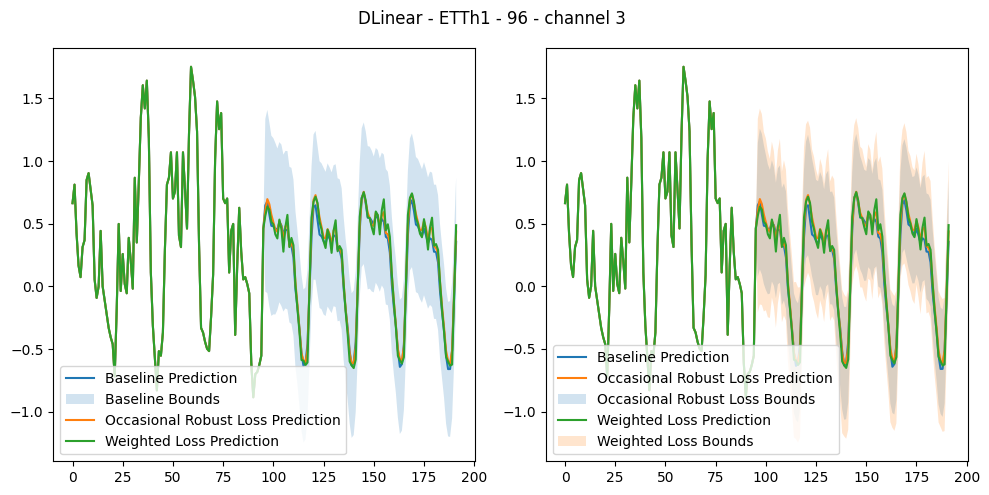

In [14]:
%matplotlib inline
model = 'DLinear'
model_map = {
    'DLinear': DLinear,
    'SegRNN': SegRNN,
    'PatchTST': PatchTST
}
model_class = model_map[model]
dataset = 'ETTh1.csv'
model_wrapper1 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='normal'))
model_wrapper2 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='occasional', n_iter=1))
model_wrapper3 = ModelWrapper(model_class, get_config_for(dataset, 96, model, training_type='weighted'))

models = [model_wrapper1, model_wrapper2, model_wrapper3]
methods = ['Baseline', 'Occasional Robust Loss', 'Weighted Loss']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for model, method in zip(models, methods):
    batch_idx = 0
    channel_idx = 3
    model.train()
    model.eval()
    model.config.batch_size = batch_idx + 1
    _, test_loader = model.get_data('test')
    for (batch_x, batch_y, _, _) in test_loader:
        break
    batch_x = batch_x.float().cuda()
    y_pred = model.forward(batch_x).cpu().detach()
    epsilon = 0.1
    lower_bound, upper_bound = batch_x - epsilon, batch_x + epsilon
    start = time.time()
    y_lower, y_upper = model.forward_bounds(lower_bound, upper_bound)
    y_lower, y_upper = y_lower.cpu().detach(), y_upper.cpu().detach()

    pred_len = model.config.pred_len
    y_pred = y_pred[batch_idx, -pred_len:, channel_idx]
    y_lower = y_lower[batch_idx, -pred_len:, channel_idx]
    y_upper = y_upper[batch_idx, -pred_len:, channel_idx]
    y_true = batch_y[batch_idx, -pred_len:, channel_idx]
    x_input = batch_x[batch_idx, -pred_len:, channel_idx].cpu()
    axs[0].plot(torch.concat([x_input, y_pred], dim=0).cpu().detach().numpy(), label=f'{method} Prediction')
    axs[1].plot(torch.concat([x_input, y_pred], dim=0).cpu().detach().numpy(), label=f'{method} Prediction')
    if method == 'Baseline':
        axs[0].fill_between(range(len(x_input) + len(y_pred)), torch.concat([x_input, y_lower], dim=0), torch.concat([x_input, y_upper], dim=0), alpha=0.2, label=f'{method} Bounds')
    else:
        axs[1].fill_between(range(len(x_input) + len(y_pred)), torch.concat([x_input, y_lower], dim=0), torch.concat([x_input, y_upper], dim=0), alpha=0.2, label=f'{method} Bounds')
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
fig.suptitle(f'{model} - {model.config.data_path.split(".")[0]} - {model.config.pred_len} - channel {channel_idx} ')
# plt.plot(torch.concat([x_input, y_true], dim=0).cpu().detach().numpy(), label='Ground Truth')
plt.tight_layout()
plt.savefig(f'bounds_{model}_{model.config.data_path.split(".")[0]}.png')
plt.show()